<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/figure8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

max min x tensor(18.4908) tensor(15.9191)
max min y tensor(14.7710) tensor(12.1518)


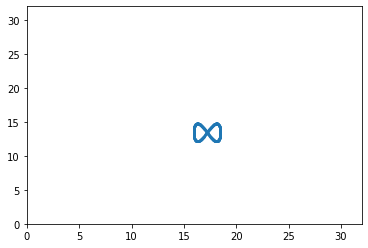

In [2]:
for i in range(1):
  t = torch.linspace(0,2*3.14159,1000)
  x = t.cos()
  y = t.sin()*t.cos()


  randMultx = np.random.uniform(1.0,8.0)
  randMulty = np.random.uniform(1.0,8.0)

  maxaddx = 14-randMultx
  maxaddy = 14-randMulty
  
  assert maxaddx >0
  assert maxaddy >0

  randAddx = np.random.uniform(-maxaddx,maxaddx)
  randAddy = np.random.uniform(-maxaddy,maxaddy)

  randMultSinx = None
  randMultSiny = None
  randAddSinx = None
  randAddSiny = None

  x = (x*randMultx)+16+randAddx
  y = (y*randMulty)+16+randAddy
  
  plt.scatter(x,y,s=1)
  plt.xlim(0,32)
  plt.ylim(0,32)
  #plt.show()
  assert torch.max(x).item() < 32
  assert torch.min(x).item() > 0
  assert torch.max(y).item() < 32
  assert torch.min(y).item() > 0
  
  print("max min x",torch.max(x),torch.min(x))
  print("max min y",torch.max(y),torch.min(y))
plt.show()

max min x tensor(29.9642) tensor(2.0004)
max min y tensor(25.0304) tensor(6.4093)


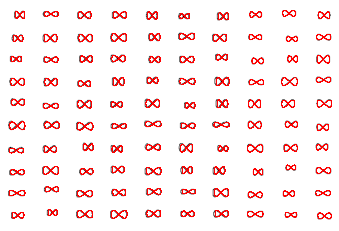

In [3]:
#add donut here
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    
    canvas = torch.zeros((length,side, side))
    x = torch.zeros((length,numpoints))
    y = torch.zeros((length,numpoints))
        
    ###
    for i in range(length):
      t = torch.linspace(0,2*3.14159,numpoints)
      x[i,:] = t.cos()
      y[i,:] = t.sin()*t.cos()

      WIDTH = 14
      randMultx = np.random.uniform(8.0,WIDTH-.1)
      randMulty = np.random.uniform(8.0,WIDTH-.1)

      maxaddx = WIDTH-randMultx
      maxaddy = WIDTH-randMulty
      
      assert maxaddx >0
      assert maxaddy >0

      randAddx = np.random.uniform(-maxaddx,maxaddx)
      randAddy = np.random.uniform(-maxaddy,maxaddy)

      randMultSinx = None
      randMultSiny = None
      randAddSinx = None
      randAddSiny = None

      x[i,:] = (x[i,:]*randMultx)+16+randAddx
      y[i,:] = (y[i,:]*randMulty)+16+randAddy

    
    print("max min x",torch.max(x),torch.min(x))
    print("max min y",torch.max(y),torch.min(y))
   
    assert torch.max(x).item() < 32
    assert torch.min(x).item() > 0
    assert torch.max(y).item() < 32
    assert torch.min(y).item() > 0
      
    ###
    
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            sample = torch.stack([sample for i in range(64)],dim = 0).cuda()
            pred = model(sample,torch.zeros(64,1000,2).cuda())#come back to this
            predres = numpoints
            X = pred[0,:,0]
            Y = pred[0,:,1]
            
            s = [.0001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            plt.plot(X.cpu(),Y.cpu(),',-',c='red', ms=.1, lw=0.1) 

    else:
        X = labels[:,0]
        Y = labels[:,1]
        s = [.0001 for x in range(numpoints)]
        c = ['red' for x in range(numpoints)]
        plt.plot(X.cpu(),Y.cpu(),',-',c='red',  ms=.1, lw=0.1) 


class DonutDataset(torch.utils.data.Dataset):
    def __init__(self, length = 10):
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0


    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        points = self.values["points"]
        points = points[idx,:]
        z = torch.zeros(numpoints,1)
        points = torch.cat([points,z], dim = 1)
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=1200)
        
dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',dataset, model = None)

In [4]:
#https://math.stackexchange.com/questions/7988/the-function-that-draws-a-figure-eight

$ t\in(-\tfrac12\pi,\tfrac32\pi)\mapsto(\cos t,\sin t\cos t)\in\mathbb R^2 $


In [5]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length = 64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


max min x tensor(29.9959) tensor(2.0006)
max min y tensor(25.8121) tensor(6.2546)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
#add model
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.hidden_dim = self.input_dim*100
        self.output_dim = 1000*2

        self.mlp = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
        )

    def forward(self, x,points):
        x = x.squeeze()
        x = torch.flatten(x,start_dim=1)
        assert x.shape == (mini_batch,self.input_dim)
        out = self.mlp(x)
        return 32.0*out.reshape(points.shape)


In [7]:
model = MLP().cuda()


In [8]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [9]:
#add training 
for i in range(40):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != 64:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    
    out = model(xin,yin[:,:,:2])
    loss = torch.mean((out-yin[:,:,:2])**2)
    loss.backward()
    optimizer.step()
  print("loss",loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss 2.565610885620117
loss 0.6846811771392822
loss 0.39510679244995117
loss 0.18996970355510712
loss 0.15526510775089264
loss 0.12953045964241028
loss 0.11634644120931625
loss 0.11037683486938477
loss 0.10489726066589355
loss 0.10131978243589401
loss 0.09376052767038345
loss 0.08962007611989975
loss 0.08626534044742584
loss 0.08870408684015274
loss 0.08172159641981125
loss 0.07929719984531403
loss 0.07789349555969238
loss 0.07576099038124084
loss 0.0747360959649086
loss 0.07189396023750305
loss 0.07051665335893631
loss 0.06761085987091064
loss 0.06659634411334991
loss 0.06496082246303558
loss 0.0657738521695137
loss 0.06160517409443855
loss 0.0632227212190628
loss 0.06009385734796524
loss 0.05962293595075607
loss 0.057638708502054214
loss 0.05467908829450607
loss 0.05365007370710373
loss 0.051860611885786057
loss 0.0532056987285614
loss 0.052035678178071976
loss 0.051360003650188446
loss 0.05102861672639847
loss 0.05005142465233803
loss 0.047798410058021545
loss 0.04694291576743126


In [10]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [11]:
#add training 
for i in range(40):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != 64:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    
    out = model(xin,yin[:,:,:2])
    loss = torch.mean((out-yin[:,:,:2])**2)
    loss.backward()
    optimizer.step()
  print("loss",loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss 0.04914335161447525
loss 0.04259306937456131
loss 0.04097241535782814
loss 0.04251152276992798
loss 0.04049212858080864
loss 0.040959179401397705
loss 0.040557704865932465
loss 0.04008522257208824
loss 0.038826752454042435
loss 0.03910374268889427
loss 0.03750435262918472
loss 0.037574462592601776
loss 0.035827070474624634
loss 0.03652434051036835
loss 0.03558918461203575
loss 0.03709955886006355
loss 0.035169053822755814
loss 0.035363808274269104
loss 0.03511226922273636
loss 0.035354889929294586
loss 0.033177345991134644
loss 0.033386919647455215
loss 0.03230345994234085
loss 0.03213293477892876
loss 0.031176798045635223
loss 0.03220413997769356
loss 0.032371193170547485
loss 0.03083140030503273
loss 0.03189638629555702
loss 0.029983337968587875
loss 0.031177785247564316
loss 0.029273660853505135
loss 0.029922738671302795
loss 0.030297579243779182
loss 0.031553782522678375
loss 0.02872934564948082
loss 0.02921818383038044
loss 0.02835753746330738
loss 0.027574578300118446
loss 0

max min x tensor(29.9922) tensor(2.0102)
max min y tensor(25.3351) tensor(6.7879)


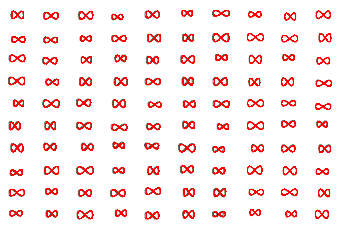

In [12]:
test_dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('testsetfit-points.png',test_dataset, model = model)


In [13]:
val_dataset = DonutDataset(length = 64)
loader_val = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=val_dataset),
    num_workers=4)


max min x tensor(29.8766) tensor(2.0073)
max min y tensor(25.7784) tensor(6.6655)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1000, 2])


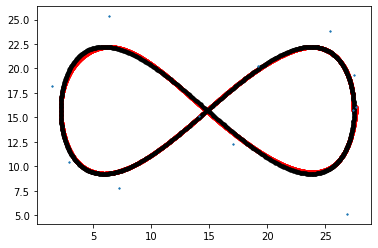

In [14]:
from scipy.interpolate import splprep, splev
from numpy import arange, cos, linspace, pi, sin, random

#display fits on validation set
xgt = None
ygt = None

out = None


for xin,yin in loader_val:
  out = model(xin.cuda(),yin[:,:,:2].cuda())
  xgt = yin[:,:,0]
  ygt = yin[:,:,1]
out = out[1,:,:]
xpred = out[:,0].detach()
ypred = out[:,1].detach()
print(out.shape)
xgt=xgt[1,:]
ygt=ygt[1,:]

t=np.linspace(0,1,1000)
z = t

# spline parameters
s=75 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([xpred.cpu().numpy(),ypred.cpu().numpy(),z],s=s,k=k,nest=-1)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,4000),tck)

ascatter = plt.scatter(xnew,ynew,s=10,c='red')
ascatter = plt.scatter(xgt.cpu().numpy(),ygt.cpu().numpy(),s=10,c='black')
ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
plt.gca().add_artist(ascatter)
